# Building and Training Llama From Scratch

Kevin Putra Santoso - Avalon AI Corporation<br>
Saturday, December 21th 2024

In [1]:
from llama_modules import Transformer
from llama_modules.model import ModelArgs
import tiktoken
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import pandas as pd
from typing import Tuple
from tqdm import tqdm

In [2]:
enc = tiktoken.get_encoding("cl100k_base")

print("Test encode - Hello world: ", enc.encode("Hello world"))
print("Test decode - Hello world: ", enc.decode(enc.encode("Hello world")))

Test encode - Hello world:  [9906, 1917]
Test decode - Hello world:  Hello world


In [3]:
# Loading data
with open('tiny_shakespeare.txt','r') as f:
    data = f.read()

token_bos = enc.encode('<|begin_of_sentence|>')[0]
token_eos = enc.encode('<|end_of_sentence|>')[0]
token_pad = enc.encode('<|pad_id|>')[0]

tensor_token_bos = torch.tensor(token_bos, dtype=torch.int, device="cuda").view(1)
tensor_token_eos = torch.tensor(token_eos, dtype=torch.int, device="cuda").view(1)
tensor_token_pad = torch.tensor(token_pad, dtype=torch.int, device="cuda").view(1)

data = enc.encode(data)

vocab = sorted(set(data))
vocab.extend([token_bos, token_eos, token_pad])
vocab_size_bpe = len(vocab)

In [4]:
itos = {i: ch for i, ch in enumerate(vocab)}
stoi = {ch: i for i, ch in enumerate(vocab)}

In [5]:
def encode(tokens):
    return [stoi[ch] for ch in tokens]

# def decode(l):
#     return ''.join(itos[i] for i in l)

def decode(l):
    return [itos[ch] for ch in l]

In [6]:
enc.decode(decode(encode(enc.encode("thou"))))

'thou'

In [7]:
params = ModelArgs(dim = 256, n_layers = 3, n_heads = 16, n_kv_heads = 4, vocab_size = vocab_size_bpe,
                   multiple_of = 128, ffn_dim_mult=1.3, norm_eps=1e-5, rope_theta = 500_000, max_seq_len=128)

model = Transformer(params).to("cuda")

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(count_parameters(model))

7285504


In [9]:
dataset = torch.tensor(encode(data), dtype=torch.int).to("cuda")
print(f"dataset-shape: {dataset.shape}")

dataset-shape: torch.Size([301829])


In [10]:
def get_dataset_batch(
    data: torch.Tensor,
    split: str,
    args: ModelArgs,
    device: str = "cuda"
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Get a batch of data for training, validation, or testing.
    
    Args:
        data: Complete dataset tensor
        split: Dataset split ("train", "val", or "test")
        args: Model arguments containing sequence length and batch size
        device: Computing device ("cuda" or "cpu")
    
    Returns:
        Tuple of (input sequences, target sequences)
    """
    # Data split ratios
    TRAIN_RATIO = 0.8
    VAL_RATIO = 0.1
    
    # Calculate split indices
    train_idx = int(TRAIN_RATIO * len(data))
    val_idx = int((TRAIN_RATIO + VAL_RATIO) * len(data))
    
    # Split data into train, validation and test sets
    splits = {
        "train": data[:train_idx],
        "val": data[train_idx:val_idx],
        "test": data[val_idx:]
    }
    
    if split not in splits:
        raise ValueError(f"Invalid split '{split}'. Must be one of: {list(splits.keys())}")
    
    batch_data = splits[split]
    seq_len = args.max_seq_len
    
    # Generate random starting indices for sequences
    indices = torch.randint(
        low=0,
        high=len(batch_data) - seq_len - 3,
        size=(args.max_batch_sz,),
        device=device
    )
    
    # Create input sequences (x) with BOS token
    x = torch.stack([
        torch.cat([tensor_token_bos, batch_data[i:i+seq_len-1]])
        for i in indices
    ]).long().to(device)
    
    # Create target sequences (y) with EOS token
    y = torch.stack([
        torch.cat([batch_data[i+1:i+seq_len], tensor_token_eos])
        for i in indices
    ]).long().to(device)
    
    return x, y

In [11]:
xs, ys = get_dataset_batch(dataset, split="train", args=params)
print(xs.shape, ys.shape)

torch.Size([32, 128]) torch.Size([32, 128])


In [12]:
def evaluate_loss(model, dataset, args):
    device = "cuda"
    out = {}
    model.eval()

    for split in ["train", "val"]:
        losses = []
        for _ in range(10):  # Evaluate over 10 batches for stability
            xb, yb = get_dataset_batch(dataset, split, args)
            xb, yb = xb.to(device), yb.to(device)
            with torch.no_grad():
                _, loss = model(tokens=xb, start_pos=0, targets=yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    return out

def train(model, optimizer, dataset, args):
    epochs = 100
    log_interval = 3
    device = "cuda"
    training_stats = []
    start_time = time.time()

    print("\nStarting Training\n")
    for epoch in tqdm(range(epochs), desc="Training Progress", unit="epoch"):
        model.train()
        optimizer.zero_grad()

        xs, ys = get_dataset_batch(dataset, 'train', args)
        xs, ys = xs.to(device), ys.to(device)
        
        _, loss = model(tokens=xs, start_pos=0, targets=ys)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % log_interval == 0:
            elapsed_time = time.time() - start_time
            eval_loss = evaluate_loss(model, dataset, args)
            training_stats.append({
                "epoch": epoch + 1,
                "train_loss": eval_loss["train"],
                "val_loss": eval_loss["val"],
                "elapsed_time": elapsed_time
            })

            print(f"Epoch {epoch + 1:3d} | Train Loss: {eval_loss['train']:.4f} | Val Loss: {eval_loss['val']:.4f} | Time: {elapsed_time:.2f}s")
            start_time = time.time()

    df_stats = pd.DataFrame(training_stats)
    df_stats.plot(x="epoch", y=["train_loss", "val_loss"], title="Training and Validation Loss")
    return df_stats


Starting Training



Training Progress:   3%|▎         | 3/100 [00:01<00:35,  2.73epoch/s]

Epoch   3 | Train Loss: 9.5383 | Val Loss: 9.5602 | Time: 0.75s


Training Progress:   6%|▌         | 6/100 [00:01<00:24,  3.81epoch/s]

Epoch   6 | Train Loss: 9.5171 | Val Loss: 9.5308 | Time: 0.14s


Training Progress:   9%|▉         | 9/100 [00:02<00:21,  4.32epoch/s]

Epoch   9 | Train Loss: 9.4909 | Val Loss: 9.5107 | Time: 0.15s


Training Progress:  12%|█▏        | 12/100 [00:03<00:20,  4.31epoch/s]

Epoch  12 | Train Loss: 9.4574 | Val Loss: 9.4801 | Time: 0.14s


Training Progress:  15%|█▌        | 15/100 [00:03<00:19,  4.27epoch/s]

Epoch  15 | Train Loss: 9.4231 | Val Loss: 9.4475 | Time: 0.15s


Training Progress:  20%|██        | 20/100 [00:04<00:15,  5.33epoch/s]

Epoch  18 | Train Loss: 9.3790 | Val Loss: 9.4031 | Time: 0.15s


Training Progress:  23%|██▎       | 23/100 [00:05<00:14,  5.30epoch/s]

Epoch  21 | Train Loss: 9.3142 | Val Loss: 9.3498 | Time: 0.16s


Training Progress:  26%|██▌       | 26/100 [00:06<00:14,  5.01epoch/s]

Epoch  24 | Train Loss: 9.2432 | Val Loss: 9.2688 | Time: 0.17s


Training Progress:  29%|██▉       | 29/100 [00:06<00:13,  5.10epoch/s]

Epoch  27 | Train Loss: 9.1488 | Val Loss: 9.1841 | Time: 0.19s


Training Progress:  32%|███▏      | 32/100 [00:07<00:12,  5.39epoch/s]

Epoch  30 | Train Loss: 9.0150 | Val Loss: 9.0572 | Time: 0.18s


Training Progress:  34%|███▍      | 34/100 [00:07<00:14,  4.45epoch/s]

Epoch  33 | Train Loss: 8.8971 | Val Loss: 8.9286 | Time: 0.16s


Training Progress:  38%|███▊      | 38/100 [00:08<00:12,  5.08epoch/s]

Epoch  36 | Train Loss: 8.7289 | Val Loss: 8.7722 | Time: 0.14s


Training Progress:  41%|████      | 41/100 [00:09<00:12,  4.85epoch/s]

Epoch  39 | Train Loss: 8.5867 | Val Loss: 8.6110 | Time: 0.22s


Training Progress:  42%|████▏     | 42/100 [00:10<00:16,  3.46epoch/s]

Epoch  42 | Train Loss: 8.4262 | Val Loss: 8.4683 | Time: 0.19s


Training Progress:  47%|████▋     | 47/100 [00:10<00:10,  5.05epoch/s]

Epoch  45 | Train Loss: 8.3202 | Val Loss: 8.3518 | Time: 0.15s


Training Progress:  49%|████▉     | 49/100 [00:11<00:11,  4.59epoch/s]

Epoch  48 | Train Loss: 8.1837 | Val Loss: 8.2410 | Time: 0.15s


Training Progress:  51%|█████     | 51/100 [00:12<00:12,  3.97epoch/s]

Epoch  51 | Train Loss: 8.0925 | Val Loss: 8.1472 | Time: 0.16s


Training Progress:  56%|█████▌    | 56/100 [00:12<00:08,  5.28epoch/s]

Epoch  54 | Train Loss: 8.0050 | Val Loss: 8.0355 | Time: 0.15s


Training Progress:  57%|█████▋    | 57/100 [00:13<00:10,  3.91epoch/s]

Epoch  57 | Train Loss: 7.9086 | Val Loss: 7.9480 | Time: 0.18s


Training Progress:  60%|██████    | 60/100 [00:14<00:09,  4.23epoch/s]

Epoch  60 | Train Loss: 7.8179 | Val Loss: 7.8702 | Time: 0.14s


Training Progress:  63%|██████▎   | 63/100 [00:14<00:08,  4.41epoch/s]

Epoch  63 | Train Loss: 7.7382 | Val Loss: 7.7861 | Time: 0.14s


Training Progress:  68%|██████▊   | 68/100 [00:15<00:05,  5.55epoch/s]

Epoch  66 | Train Loss: 7.6496 | Val Loss: 7.7144 | Time: 0.15s


Training Progress:  69%|██████▉   | 69/100 [00:16<00:07,  4.06epoch/s]

Epoch  69 | Train Loss: 7.5970 | Val Loss: 7.6435 | Time: 0.16s


Training Progress:  74%|███████▍  | 74/100 [00:16<00:04,  5.44epoch/s]

Epoch  72 | Train Loss: 7.5350 | Val Loss: 7.5876 | Time: 0.15s


Training Progress:  76%|███████▌  | 76/100 [00:17<00:05,  4.51epoch/s]

Epoch  75 | Train Loss: 7.4663 | Val Loss: 7.5183 | Time: 0.15s


Training Progress:  80%|████████  | 80/100 [00:18<00:03,  5.10epoch/s]

Epoch  78 | Train Loss: 7.3967 | Val Loss: 7.4780 | Time: 0.17s


Training Progress:  82%|████████▏ | 82/100 [00:18<00:04,  4.37epoch/s]

Epoch  81 | Train Loss: 7.3582 | Val Loss: 7.4082 | Time: 0.16s


Training Progress:  86%|████████▌ | 86/100 [00:19<00:02,  4.78epoch/s]

Epoch  84 | Train Loss: 7.2871 | Val Loss: 7.3842 | Time: 0.15s


Training Progress:  87%|████████▋ | 87/100 [00:20<00:03,  3.66epoch/s]

Epoch  87 | Train Loss: 7.2513 | Val Loss: 7.3350 | Time: 0.21s


Training Progress:  92%|█████████▏| 92/100 [00:21<00:01,  5.03epoch/s]

Epoch  90 | Train Loss: 7.2087 | Val Loss: 7.3017 | Time: 0.15s


Training Progress:  93%|█████████▎| 93/100 [00:21<00:01,  3.73epoch/s]

Epoch  93 | Train Loss: 7.1761 | Val Loss: 7.2617 | Time: 0.16s


Training Progress:  98%|█████████▊| 98/100 [00:22<00:00,  5.20epoch/s]

Epoch  96 | Train Loss: 7.1252 | Val Loss: 7.2305 | Time: 0.15s


Training Progress: 100%|██████████| 100/100 [00:23<00:00,  4.34epoch/s]

Epoch  99 | Train Loss: 7.1048 | Val Loss: 7.1973 | Time: 0.15s


,epoch,train_loss,val_loss,elapsed_time
0,3,9.538319,9.560215,0.746031
1,6,9.517097,9.530836,0.143494
2,9,9.490864,9.510658,0.149390
3,12,9.457370,9.480140,0.144589
4,15,9.423099,9.447482,0.146657
5,18,9.378978,9.403074,0.145860
6,21,9.314157,9.349755,0.157472
7,24,9.243163,9.268807,0.171953
8,27,9.148757,9.184093,0.185582
9,30,9.015039,9.057200,0.176991


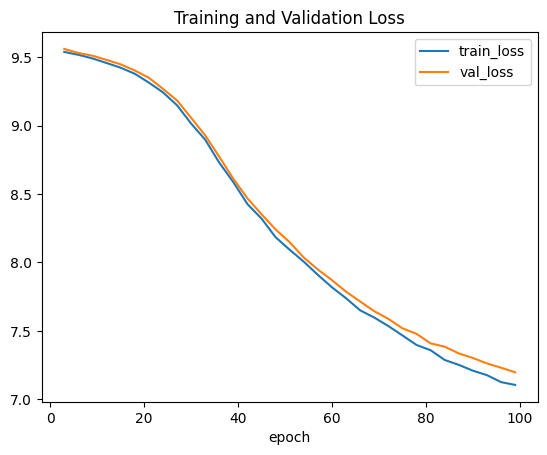

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train(model, optimizer, dataset, params)

## Proses Inferensi akan dilanjutkan pada Part 2